## TP5  - Computer Vision

In [1]:
import pandas as pd
import numpy as np
import time
import torch
import cv2 as cv
import matplotlib.pyplot as plt

### Implementar el detector de fondo naive usando la mediana como estimador. El algoritmo debe recibir el parámetro N (cantidad de frames utilizados para la estimación) y el intervalo de tiempo para recalcular el fondo. Se deben generar las mascaras de foreground y aplicarlas a los frames para segmentar los objetos en movimiento.

In [2]:
filename = r'C:\Users\Leandro\Desktop\Inteligencia Artificial\3er Bimestre\Computer Vision\vtest.avi'

In [51]:
def BG(file, n_frames, time_update, stats = False):

    capture = cv.VideoCapture(file)
    total_frames = capture.get(cv.CAP_PROP_FRAME_COUNT)
    
    S = time_update
    N = n_frames
    time_list = []
    non_zero_list = []
    
    if not capture.isOpened:
        print('Falla al abrir el archivo: ' + file)
        exit(0)
        
    # Calculo la primera mediana
    frameIds = 60 * np.random.uniform(size = N)
    frame_list = []
    for i in frameIds:
        capture.set(1, i)
        ret, frame_ = capture.read()
        frame_list.append(frame_)

    M = np.median(frame_list, axis = 0)     
    
    start = time.time()
    
    while True:
        # Leemos un frame
        ret, frame = capture.read()
        if frame is None:
            break
        
        start_frame = time.time()
        # Número de frame actual
        frame_number = int(capture.get(cv.CAP_PROP_POS_FRAMES))
        
        # Calculo la mediana
        end = time.time()
        t = end - start
        if t > S:
            frameIds = frame_number + np.random.uniform(-5 * S, 5 * S, size = N)
            frameIds = np.maximum(np.minimum(frameIds, total_frames), 0).astype(int)
            frame_list = []
            for i in frameIds:
                capture.set(1, i)
                ret, frame_ = capture.read()
                frame_list.append(frame_)
        
            M = np.median(frame_list, axis = 0)
            capture.set(1, frame_number)
            start = time.time()
       
        # Escribimos sobre la imagen el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(frame_number), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        cv.putText(frame, str(int(t)), (75, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        
        # Mostramos frame original e imagen binaria background/foreground
        cv.imshow('Frame', frame)
        #frame = cv.medianBlur(frame.astype('float32'), 5)
        #M = cv.medianBlur(M.astype('float32'), 5)
        #frame = cv.GaussianBlur(frame.astype('float32'), (5, 5), 1)
        #M = cv.GaussianBlur(M.astype('float32'), (5, 5), 1)
        gray_img = np.abs(frame.astype('float32') - M.astype('float32'))
        gray_img = cv.medianBlur(gray_img, 3)
        gray_img = cv.GaussianBlur(gray_img, (5, 5), 0.5)
        gray_img = cv.cvtColor(gray_img, cv.COLOR_BGR2GRAY)
        thresh, bg = cv.threshold(gray_img, 127, 255, cv.THRESH_BINARY)
        #bg = cv.GaussianBlur(bg, (5, 5), 0.5)
        cv.imshow('BG', bg)
        end_frame = time.time()
        time_between_frames = end_frame - start_frame
        time_list.append(time_between_frames)
        non_zero_list.append(np.count_nonzero(bg))
        
        # Corremos hasta que termine o apriete escape
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
    
    cv.destroyAllWindows()
    capture.release()
    
    if stats == True:
        return time_list, non_zero_list

In [38]:
BG(filename, 50, 40)

### Comparar con alguno de los métodos vistos en la práctica basados en mezcla de gaussianas.

Vamos a comparar el algoritmo de mediana que acabamos de hacer con el algoritmo de sustracción de fondo MOG2. Para ello vamos a tomar 4 métricas:
* promedio de tiempo de procesado entre frames
* desvío estándar de tiempo de procesado entre frames
* promedio de elementos distinto de cero entre frames
* desvío estándar de elementos distinto de cero entre frames

Los elementos distitos de cero son los píxeles que identifica que no son parte del fondo, o sea los blancos.

In [39]:
metodo = 'MOG2'
#metodo = 'KNN'
if metodo == 'MOG2':
    backSub = cv.createBackgroundSubtractorMOG2()
else:
    backSub = cv.createBackgroundSubtractorKNN()
    backSub = cv.createBackgroundSubtractorKNN(detectShadows = True)

In [61]:
# Abrimos el archivo
#-------------------
capture = cv.VideoCapture(filename)
time_mog = []
nonzero_mog = []

if not capture.isOpened:
    print('Falla al abrir el archivo: ' + filename)
    exit(0)

# Corremos la sustraccion
#------------------------
while True:
    # Leemos un frame
    ret, frame = capture.read()
    if frame is None:
        break
    
    # Aplicamos la sustracción al frame leído
    #----------------------------------------
    # Cada frame se utiliza tanto para calcular la máscara de primer plano como para actualizar el fondo.
    # Si se desea cambiar la tasa de aprendizaje utilizada para actualizar el modelo de fondo, es posible
    # establecer una tasa de aprendizaje específica pasando un parámetro al método apply.
    start = time.time()
    fgMask = backSub.apply(frame)
    
    # Escribimos sobre la imagen el número de frame procesado
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    # mostramos frame original e imagen binaria background/foreground
    cv.imshow('Frame', frame)
    cv.imshow('FG Mask', fgMask)
    end = time.time()
    t = end - start
    time_mog.append(t)
    nonzero_mog.append(np.count_nonzero(fgMask))
    
    # Corresmos hasta que termine o apriete escape
    keyboard = cv.waitKey(30)
    if keyboard == 'q' or keyboard == 27:
        break

cv.destroyAllWindows()
capture.release()

In [52]:
time_median, nonzero_median = BG(filename, 50, 40, stats = True)

In [64]:
mean_time_median = np.mean(time_median)
std_time_median = np.std(time_median)
mean_time_mog = np.mean(time_mog)
std_time_mog = np.std(time_mog)

In [72]:
mean_nonzero_median = np.mean(nonzero_median)
std_nonzero_median = np.std(nonzero_median)
mean_nonzero_mog = np.mean(nonzero_mog)
std_nonzero_mog = np.std(nonzero_mog)

In [75]:
mediana = np.round([mean_time_median, std_time_median, mean_nonzero_median, std_nonzero_median], 4)
mog = np.round([mean_time_mog, std_time_mog, mean_nonzero_mog, std_nonzero_mog], 4)

In [78]:
rows = ['mean_time', 'std_time', 'mean_nonzero', 'std_nonzero']

In [79]:
table = pd.DataFrame({'LABELS': rows, 'MEDIANA': mediana, 'MOG': mog})                

In [81]:
table

,LABELS,MEDIANA,MOG
0,mean_time,0.0113,0.0043
1,std_time,0.0024,0.0010
2,mean_nonzero,4275.2303,13752.3937
3,std_nonzero,1167.6492,4378.8580


In [89]:
print(1/(table['MOG'][0]/table['MEDIANA'][0]))
print((table['MOG'][2]/table['MEDIANA'][2]))

2.627906976744186
3.2167609075936796


Podemos ver que el algoritmo de MOG2 es mucho más eficiente para el cálculo entre frames (2.62 veces más rápido) e identifica 3 vece más de píxeles blancos, pero con 4 veces más de desvío estándar. Esto quiere decir que frame a frame identifica de manera variable, mientras que el de mediana, al tener menor dispersión, es más rígido e identifica

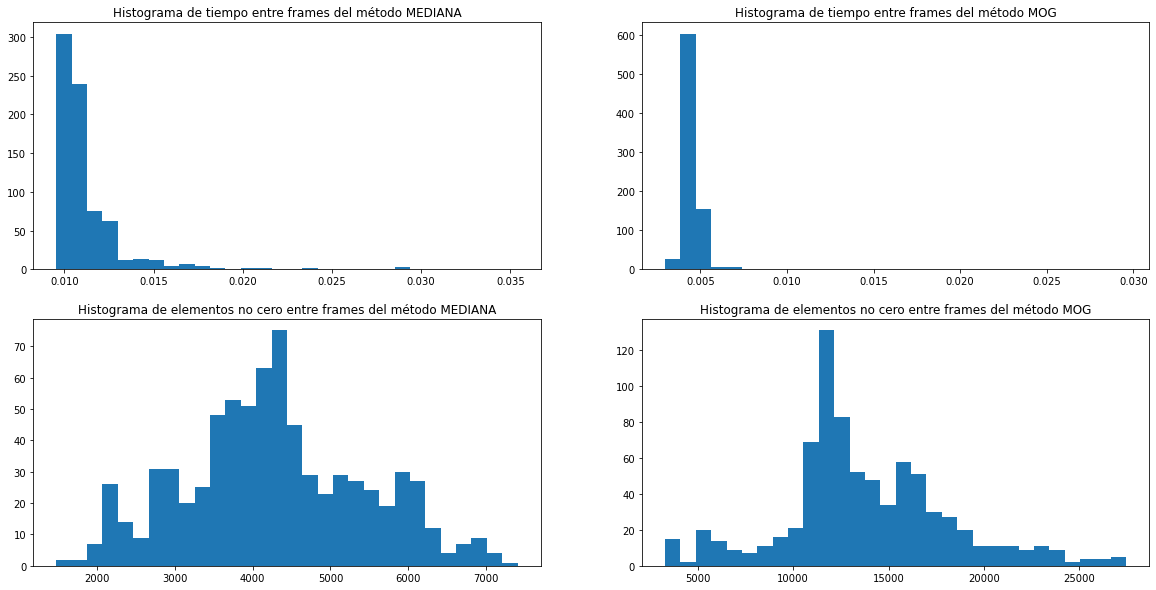

In [82]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))

axs[0,0].hist(time_median, bins = 30)
axs[0,0].set_title('Histograma de tiempo entre frames del método MEDIANA')
axs[1,0].hist(nonzero_median, bins = 30)
axs[1,0].set_title('Histograma de elementos no cero entre frames del método MEDIANA')
axs[0,1].hist(time_mog, bins = 30)
axs[0,1].set_title('Histograma de tiempo entre frames del método MOG')
axs[1,1].hist(nonzero_mog, bins = 30)
axs[1,1].set_title('Histograma de elementos no cero entre frames del método MOG')
plt.show()